# Demo Notebook: Discrete Time

In this notebook, we'll demonstrate using some of the functions in the custom `AdaptiveOpinions` package (we can change the name). 

Unchitta's [amazing blog post](https://unchitta.com/blog/2020/10/deffuant-weisbuch-julia/) does a great job of explaining the organization of the simulation code, despite the fact that she has never in fact seen this code...her implementation is excellent and I am going to keep looking for tricks to steal from her. 

The model dynamics as implemented in this package have the form:

$$x_i^{t+1} = \lambda_i g(x_i^t) + (1-\lambda_i)\frac{1}{\sum_{j\sim i}f(x_i^t, x_j^t)} \sum_{i\sim j} f(x_i^t, x_j^t)x_j^t\;,  $$

where the function $f$ is parameterized as 

$$ f(x,y) = \frac{\beta}{1 + e^{-\gamma(d(x,y) - \delta)}}\;, $$

with tunable parameters $\beta$, $\gamma$, and $\delta$. It might be fun to play with $g$ too, but in the below code I just set $g(x) = x$. 

First up, let's load some packages. In addition to the custom package, we have packages for working with networks, and then a bunch of visualization libraries. 

In [1]:
using AdaptiveOpinions # package with custom code. 
using LightGraphs      # simple and efficient network data structures. 
using GraphPlot        # for viz
using Plots            # for more viz

using Cairo            # for saving images
using Statistics       # for convenience functions like mean()

┌ Info: Precompiling AdaptiveOpinions [055d758e-89cc-45f6-a4b4-9234161ec2cb]
└ @ Base loading.jl:1260


Let's graph a sample graph to play with. 

In [2]:
G = graphfamous("polbooks") # get a graph to play with. 
                          # options: "karate", "football", "dolphins", "netscience", "polbooks", "power", "cond-mat"

n = nv(G)                 # number of vertices

105

## Model Initialization

Ok, now we're ready to construct the model. 

The custom code defines a special `opinion_state` data structure, which is just a collection of custom `agents`. Each agent has an opinion `x` and a stubbornness $\lambda$. So far, the easiest way to create one of these things from a graph is to use `randomInitialization`, which will just randomly set all the opinions. One can then go in and change them manually. 

In [3]:
# start with a random model state
S = randomInitialization(G);

# now give groups of nodes opposing opinions, arbitrarily
for i ∈ vertices(G)
    S[i].x = i > 14 ? 1.0 : -1.0
    S[i].λ = 0.5
end

# agent 1 is a zealot
S[9].x   = 1
S[9].λ   = 1

# agent n is an opposing zealot
S[75].x = -1
S[75].λ = 1;

Let's visualize this model state. 

In [4]:
function plotState(S::AdaptiveOpinions.opinion_state, locs_x, locs_y, color_pal)
    X = stateVector(S);
    node_colors = [color_pal[trunc(Int, 1.0+(n_colors-1.0)*(x[1]+1.0)/2.0)] for x in X]
    zealots = [S.agents[i].λ == 1 for i ∈ 1:n]
    zealot_highlight = [zealots[i] ? colorant"black" : nothing for i ∈ 1:n]
    p = gplot(S.G, locs_x, locs_y, nodefillc = node_colors, nodestrokec = zealot_highlight, nodestrokelw = 1)
    return p
end

locs_x, locs_y = spring_layout(G)

# plotting colors
n_colors = 30
color_pal = range(colorant"lightseagreen", stop=colorant"orange", length=n_colors);

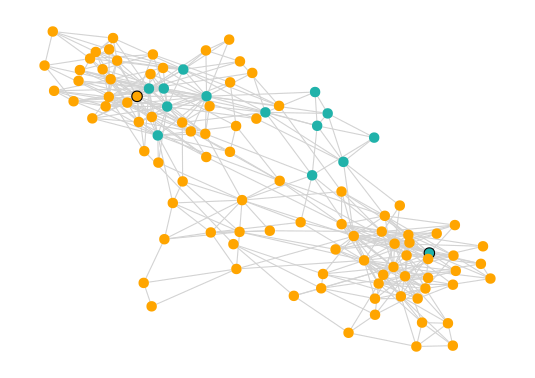

In [5]:
plotState(S, locs_x, locs_y, color_pal)

## Running Dynamics

To run the dynamics, we need to specify the parameters $\gamma$, $\beta$, and $\delta$. We then need to specify the functions $f$ and $g$, above, with these parameters. 

In [6]:
γ = 1.0
β = 1.0
δ = 0.2

0.2

In [7]:
g(x) = x
f(x1, x2) = logistic_sigmoid(x1, x2; β = β, γ = γ, δ = δ)

f (generic function with 1 method)

Ok, ready! The `evolve!` function will advance the dynamics by one timestep. 

> Sidebar: by convention, functions that modify objects in Julia end with `!`, which always makes me feel like I am screaming at my code. 

In [9]:
for i in 1:1000 evolve!(S, f, g) end

Let's take another look: 

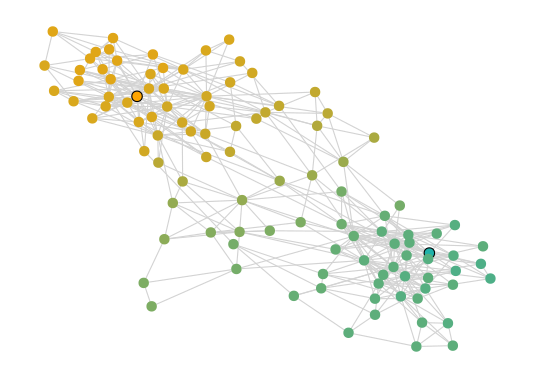

In [10]:
plotState(S, locs_x, locs_y, color_pal)

# Observing Interesting Behaviors

Observing the [bifurcation/phase transition/critical point??] that we talked about is just a matter of doing this over and over again. In touching up the code, I defined what might be a better order parameter: it's the largest distance in opinion space between two adjacent nodes. 

In [11]:
function order_parameter(S)
    maximum([abs(S[src(e)].x - S[dst(e)].x) for e in edges(S.G)])
end

function experiment(γ)
    f(x1, x2) = logistic_sigmoid(x1, x2; β = 1.0, γ = γ, δ = δ)
    for i = 1:3000 evolve!(S, f, g) end
    return order_parameter(S)
end

experiment (generic function with 1 method)

In [12]:
Γ = reverse(collect(1:0.1:4))
V = [experiment(γ) for γ ∈ Γ];

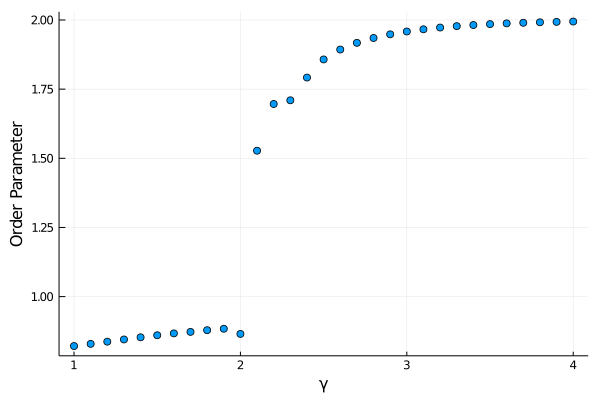

In [13]:
plot(Γ, V, 
     seriestype = :scatter, 
     label = "",
     xlabel = "γ",
     ylabel = "Order Parameter")